# DMS and DUAL-IPA allele overlap

Very limited number of gene/alleles overlapped, skip for Pillar paper.

In [13]:
# imports
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')
sys.path.append("../..")
from utils import *

In [11]:
dualipa_final_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/dual_ipa/3_outputs/annotated_perturbation_scores.csv", infer_schema_length=100000)
dualipa_final_df = dualipa_final_df.with_columns(
    pl.col("nuc_loc").cast(pl.Int64).alias("nuc_loc")
)
dualipa_final_df

symbol,node_type,nt_change,aa_change,pla,well,coordinates,n_cells,orf_id,mut_id,valid_well,avg_gfp,avg_mcherry,avg_GFP_mCherry_ratio,wt_GFP_mCherry_ratio,allele_wt_ratio,zscore,zcat,allele_wt_log2fc,zscore_log2fc_mean_norm_by_all_wt_mean,allele_wt_log2fc_pvalue,zscore_log2fc_mean_norm_by_each_wt,symbol_right,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change_right,aa_change_right,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,…,SomaticClinicalImpact_dbnsfp,SomaticClinicalImpactLastEvaluated_dbnsfp,ReviewStatusClinicalImpact_dbnsfp,Oncogenicity_dbnsfp,OncogenicityLastEvaluated_dbnsfp,ReviewStatusOncogenicity_dbnsfp,SCVsForAggregateGermlineClassification_dbnsfp,SCVsForAggregateSomaticClinicalImpact_dbnsfp,SCVsForAggregateOncogenicityClassification_dbnsfp,clinvar_nt_change_dbnsfp,clinvar_aa_change_dbnsfp,RefSeq_mRNA_dbnsfp,StarStatus_dbnsfp,clinvar_clnsig_clean_dbnsfp,plddt,rsa,OMIM_IDs,inheritance_pattern,disease_modules,disease_module_count,OMIM_disease_names,gene_allele,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2fc_median_norm_by_each_wt,dualipa_abun_score,dualipa_abun_change,dualipa_abun_chg_dir,plddt_f32,rsa_f32,RSA_Category,pLDDT_Category
str,str,str,str,i64,str,str,i64,i64,i64,bool,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,f64,str,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,i64,f64,f64,str,str,f64,f64,str,str
"""KCNJ2""","""allele""","""821A>T""","""Asp274Val""",11,"""H06""","""11_H06""",4976,100016069,2638,true,1736.815259,5002.388278,0.851111,1.862762,0.456908,-1.775144,-1,-1.130024,-4.834053,0.000001,-3.08904,"""KCNJ2""","""ENSG00000123700""","""CCSBVarC008340""","""ALE00008326""","""NC_000017.11:70175860:A:T""","""821A>T""","""Asp274Val""","""Edgotyping3""","""VUSMutGDEh010""","""D06""","""GDEhDisVCh_40005""","""C10""",1.0,"""VUSMutGDDh010""","""D06""",…,"""-""","""-""","""-""","""-""","""-""","""-""","""SCV000223548""","""-""","""-""","""821A>T ""","""Asp274Val""","""NM_000891.3""",1.0,"""4_VUS""",93.79,0.306748,null,null,"""Rare genetic cardiac disease; …",2,null,"""KCNJ2_Asp274Val""",897.920013,2918.650024,0.253414,0.841771,0.301048,-2.53293,-2,-3.99069,-3.08904,"""Uncertain""","""Increase""",93.79,0.306748,"""10-90""",""">90"""
"""PKP2""","""allele""","""1415A>G""","""Lys472Arg""",19,"""F05""","""19_F05""",2900,54308,3072,true,960.198308,1368.839077,0.887373,0.924631,0.959706,-0.247815,0,-0.059336,-0.181273,0.856153,-0.18025,"""PKP2""","""ENSG00000057294""","""CCSBVarC008023""","""ALE00008009""","""NC_000012.12:32841169:T:C""","""1415A>G""","""Lys472Arg""","""Edgotyping3""","""VUSMutGDEh015""","""H02""","""GDEhDisVCh_40015""","""E08""",1.0,"""VUSMutGDDh015""","""H02""",…,"""-""","""-""","""-""","""-""","""-""","""-""","""SCV000236225|SCV000761608|SCV0…","""-""","""-""","""1415A>G ""","""Lys472Arg""","""NM_001005242.3""",2.0,"""4_VUS""",96.38,0.014634,"""['609040']""","""autosomal dominant""","""Rare genetic cardiac disease; …",2,"""ARRHYTHMOGENIC RIGHT VENTRICUL…","""PKP2_Lys472Arg""",718.52002,912.559998,0.674567,0.629182,1.072134,0.115417,0,0.244007,-0.18025,"""N""","""Increase""",96.38,0.014634,"""<10""",""">90"""
"""KCNJ2""","""allele""","""899G>A""","""Gly300Asp""",11,"""D07""","""11_D07""",8822,100016069,2641,true,1801.536166,6450.702463,0.526546,1.862762,0.282669,-2.304423,-2,-1.822812,-7.844631,4.3423e-15,-4.97117,"""KCNJ2""","""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""899G>A""","""Gly300Asp""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""",1.0,"""VUSMutGDDh010""","""G06""",…,"""-""","""-""","""-""","""-""","""-""","""-""","""SCV001446813|SCV004571381""","""-""","""-""","""899G>A ""","""Gly300Asp""","""NM_000891.3""",2.0,"""1_Pathog

In [4]:
pillar_clinvar_df = pl.read_csv(
    "../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    ## all use Int64 for consistency
    pl.col("hg38_start").cast(pl.Int64).alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant"),
    pl.lit(True).alias("pillar_tested")
)
print("Original pillar dataset shape:", pillar_clinvar_df.shape)
print("Original pillar dataset gene:", pillar_clinvar_df.unique(["Gene"]).shape[0])
print("Original pillar dataset variant:", pillar_clinvar_df.unique(["gene_variant"]).shape[0])

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of filtered missense/SNP pillar unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of filtered missense/SNP pillar unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1053945, 103)
Original pillar dataset gene: 41
Original pillar dataset variant: 217045
Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of filtered missense/SNP pillar unique genes: 33
Number of filtered missense/SNP pillar unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,pillar_tested,aa_change
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,bool,str
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Asp""",true,"""Ala148Asp"""
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Asp""",true,"""Ala148Asp"""
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3483509,"""ASPA_Ala148Gly""",true,"""Ala148Gly"""
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_

In [15]:
dualipa_pillar_df = dualipa_final_df.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner",
)
dualipa_pillar_df.shape

(30, 666)

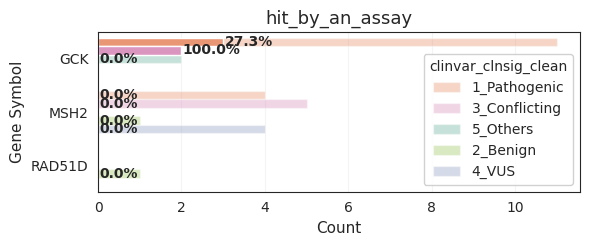

,symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc,total_counts_all
0,GCK,1_Pathogenic,11,3,27.272727,15
1,GCK,3_Conflicting,2,2,100.000000,15
2,GCK,5_Others,2,0,0.000000,15
3,MSH2,1_Pathogenic,4,0,0.000000,14
4,MSH2,2_Benign,1,0,0.000000,14
5,MSH2,3_Conflicting,5,0,0.000000,14
6,MSH2,4_VUS,4,0,0.000000,14
7,RAD51D,2_Benign,1,0,0.000000,1


In [14]:
plot_gene_level_summary(
    dualipa_pillar_df.with_columns(
        (
            (pl.col("dualipa_abun_change")=="Y")
        ).alias("hit_by_an_assay"),
        pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"]
)